In [1]:
import json
import pandas as pd
from pathlib import Path
from dataclasses import dataclass, asdict
# https://medium.com/willhanchen/%E8%87%AA%E7%84%B6%E8%AA%9E%E8%A8%80%E8%99%95%E7%90%86-spacy-%E5%88%9D%E6%8E%A2%E5%BC%B7%E5%A4%A7%E7%9A%84%E5%B7%A5%E5%85%B7%E5%BA%ABspacy-%E8%AE%93%E6%A9%9F%E5%99%A8%E8%AE%80%E6%87%82%E6%88%91%E5%80%91%E7%9A%84%E8%AA%9E%E8%A8%80%E5%90%A7-4a35daa895d0
import spacy
from spacy.cli import download
import nltk
from nltk.corpus import stopwords
import string
import re

import gensim
from gensim.models import FastText, word2vec, Word2Vec
from gensim.utils import tokenize
import numpy as np
from tqdm import tqdm


# for model
import torch
import torch.nn as nn
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger
import math
from natsort import natsorted

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split   
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Callable

In [ ]:
torch.set_float32_matmul_precision('high')

In [2]:
BUILD_TEXT_DATA = False 
LOAD_TEXT_DATA = True

In [3]:
# PATH config
ALL_OUTPUT_PATH = "./"

## Text

In [4]:
class TextData:
    # embedding model use fasttext
    def __init__(self, train_data:pd.DataFrame, test_data:pd.DataFrame):
        self.train_data = train_data
        self.test_data = test_data
        self.embedding_model_name = None
        
        self.setup()
        return 
    
    def train_embedding_model(self, result_files:dict, model_type:str="skipgram", embedding_size:int=100):
        self.embedding_model_name = model_type
        data_folder = Path(result_files["folder"])
        file_to_train = data_folder / result_files["embedding_training"]
        
        sentences = word2vec.LineSentence(file_to_train)
        
        self.model = FastText(
            sentences,
            vector_size=embedding_size,
            window=5,
            min_count=1,
            sg=1 if model_type == "skipgram" else 0, # skipgram = 1, cbow = 0
            hs=0,
            negative=5,
            epochs=10,
        )
        
        model_folder = Path("model")
        model_folder.mkdir(exist_ok=True, parents=True)
        
        model_file_name =  f"{model_type}.model"
        self.model.save(str(model_folder / model_file_name))
        
        return {"model_folder": str(model_folder), "model_file_name":model_file_name, "model_type": model_type}
    
    def load_embedding_model(self, model_path:str):
        self.embedding_model_name = model_path
        self.model = FastText.load(model_path)
        
        return
    
    def setup(self):
        # 第一次執行需要下載停用詞資源
        nltk.download("stopwords")
        download("en_core_web_sm")
        self.nlp = spacy.load("en_core_web_sm")
        return
    
    def clean_text_spacy(self, text:str) -> str:
        condition = lambda token : not token.is_stop and not token.is_punct and not token.is_digit
        
        doc = self.nlp(text)
        # 篩選出非停用字、非標點符號、非數字的 token，並轉為小寫
        tokens = [token.text.lower() for token in doc if condition(token)]
        return " ".join(tokens)
    
    def clean_text_nltk(self, text: str) -> str:
        # 轉成小寫
        text = text.lower()
        # 移除數字
        text = re.sub(r'\d+', '', text)
        # 移除標點符號
        text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        # 移除多餘空白
        text = text.strip()
        # 斷詞
        tokens = text.split()
        # 移除停用字
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]
        # 回傳清理後的結果
        return " ".join(tokens)
    
    def batch_process_text(self, process_funcs:list[Callable], max_workers:int=None):
        result = []
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_func) for process_func in process_funcs]
            for future in as_completed(futures):
                result.append(future.result())
                
        return result
    
    def wrapper_function(self,id_:int, type_:int, headline_in:str, short_description_in:str, label:int, process_func:str):
        
        def process_it():
            headline = process_func(headline_in)
            short_description = process_func(short_description_in)
            item = "<CLS> " + headline + " <SEP> " +  short_description + " <END>"
            return {"id": id_, "type": type_, "process_text": item, "label": label}
        
        return process_it
    
    
    def process_all_data(self, process:str, batch_size:int=100, max_workers:int=None):
        process_func = self.clean_text_spacy if process == "spacy" else self.clean_text_nltk
        
        train_data_df = self.train_data[["id" , "headline", "short_description", "label"]].copy()
        train_data_df["type"] = "train"
        test_data_df = self.test_data[["id" ,"headline", "short_description"]].copy()
        test_data_df["type"] = "test"
        test_data_df["label"] = "IDK"
        
        data_df = pd.concat([train_data_df, test_data_df], axis=0)
        
        
        jobs = []
        for _, row in tqdm(data_df.iterrows(), total=data_df.shape[0], desc="Build Jobs"):
            id_ = row["id"]
            type_ = row["type"]
            headline = row["headline"]
            short_description = row["short_description"]
            label = row["label"]
            
            # 使用 wrapper_function 來包裝 process_func
            job = self.wrapper_function(id_, type_, headline, short_description, label , process_func)
            jobs.append(job)
        
        result = []
        for batch in tqdm(range(0, len(jobs), batch_size), desc="Processing text"):
            batch_jobs = jobs[batch:batch + batch_size]
            out = self.batch_process_text(batch_jobs, max_workers)
            result.extend(out)
        
        
        output_df = pd.DataFrame(result)
        
        folder = Path("temp")
        folder.mkdir(exist_ok=True, parents=True)
        
        prefix = f"temp_{process}"
        
        # to temp file for embedding
        with open(folder / f"{prefix}.txt", "w", encoding="utf-8") as f:
            # add special tokens
            f.write("<PAD> <CLS> <SEP> <END> <UNK>\n")
            for text in output_df["process_text"]:
                f.write(text + "\n")
        
        # save processed data
        output_df.to_csv(folder / f"{prefix}.csv", index=False)
        
        output_dict = {"folder":str(folder), "embedding_training" :f"{prefix}.txt", "record": f"{prefix}.csv" }
        # split train test data
        train_test_path = TextData.split_train_test_data(output_dict)
        
        return output_dict | train_test_path
    
    @staticmethod
    def split_train_test_data(process_all_data_output:dict):
        
        folder = process_all_data_output["folder"]
        folder = Path(folder) 
        record_file = process_all_data_output["record"]
        record_path = folder / record_file
        df = pd.read_csv(record_path, low_memory=False, dtype={"process_text": str})
        
        df_train = df[df["type"] == "train"].copy()
        df_test = df[df["type"] == "test"].copy()
        
        df_train = df_train.sort_values(by=["id"]).reset_index(drop=True)
        df_test = df_test.sort_values(by=["id"]).reset_index(drop=True)
        
        df_train = df_train.drop(columns=["type"])
        df_test = df_test.drop(columns=["type"])
        
        prefix = record_file.replace(".csv", "")    
        
        train_file = folder / f"{prefix}_train.csv"
        test_file = folder / f"{prefix}_test.csv"
        
        df_train.to_csv(train_file, index=False)
        df_test.to_csv(test_file, index=False)
        return {"train_path": str(train_file), "test_path": str(test_file)}
    
    
    @staticmethod
    def load_from_folder(folder:str): 
        path = Path(folder)
        if not path.exists():
            raise FileNotFoundError(f"Folder {folder} does not exist.")
        
        train_data_json = path / "News_train.json"
        test_data_json = path / "News_test.json"
        
        with open(train_data_json, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            train_data = [json.loads(line) for line in lines]   
            
        with open(test_data_json, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            test_data = [json.loads(line) for line in lines]
        
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
        
        return TextData(train_data, test_data)
    
    
    def tokenize(self, text:str | list[str]) -> np.ndarray:
        # 使用 FastText 模型進行斷詞
        unk_id = self.model.wv.key_to_index.get("<UNK>", 0)
        
        if isinstance(text, str):
            text_ls = text.split()
        elif isinstance(text, list):
            text_ls = text

        token_nums = [
            self.model.wv.key_to_index.get(text, unk_id)
            for text in text_ls
        ]
        
        return token_nums
    
    
    def embedding_data(self):
        vocab = self.model.wv.index_to_key
        vocab_size = len(vocab)
        embed_dim = self.model.wv.vector_size
        embedding_weight = torch.FloatTensor(
            np.array([self.model.wv[word] for word in vocab])
        )
        
        return {
            "vocab": vocab,
            "vocab_size": vocab_size,
            "embed_dim": embed_dim,
            "embedding_weight": embedding_weight
        }
        
    @staticmethod
    def get_cross_entry_weights(folder_counts:dict) -> list[float]:
        total_samples = sum(folder_counts.values())
        num_classes = len(folder_counts)
        class_weights = {
            class_id: total_samples / (num_classes * count) 
            for class_id, count in folder_counts.items()
        }

        class_weights = {
            k: v for k, v in sorted(class_weights.items(), key=lambda item: item[0])
        }
        
        # 將權重轉換為 tensor 並標準化
        weights = torch.tensor(list(class_weights.values()), dtype=torch.float)
        weights = weights / weights.sum()

        return weights.tolist()
    
    def ce_weights(self):
        return self.get_cross_entry_weights(self.train_data["label"].value_counts().to_dict())

In [5]:
DATA_FOLDER = "./2025-deep-learning-hw-2-text-classification"

In [6]:
text_data = TextData.load_from_folder(DATA_FOLDER)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/keithlin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
PROCESS_TYPE = "spacy"
PROCESS_DATA_BATCH_SIZE = 1000

In [8]:
if BUILD_TEXT_DATA:
    output = text_data.process_all_data(PROCESS_TYPE, batch_size=PROCESS_DATA_BATCH_SIZE)

In [9]:
if LOAD_TEXT_DATA:
    folder = Path("temp")
    folder.mkdir(exist_ok=True, parents=True)

    prefix = f"temp_{PROCESS_TYPE}"
    output = {
        "folder":str(folder), 
        "embedding_training" :f"{prefix}.txt", 
        "record": f"{prefix}.csv",
        "train_path":f"{prefix}_train.csv", 
        "test_path": f"{prefix}_test.csv" 
    }
    print(output)

{'folder': 'temp', 'embedding_training': 'temp_spacy.txt', 'record': 'temp_spacy.csv', 'train_path': 'temp_spacy_train.csv', 'test_path': 'temp_spacy_test.csv'}


In [10]:
EMBEDDING_METHOD = "skipgram"
EMBEDDING_SIZE = 128

In [11]:
if BUILD_TEXT_DATA:
    model_file = text_data.train_embedding_model(output, model_type=EMBEDDING_METHOD, embedding_size=EMBEDDING_SIZE)

In [12]:
if LOAD_TEXT_DATA:
    model_file = {"model_folder": "model", "model_file_name":f"{EMBEDDING_METHOD}.model", "model_type": EMBEDDING_METHOD}

In [13]:
EMBEDDING_MODEL_PATH = Path(model_file["model_folder"]) / model_file["model_file_name"]

In [14]:
if LOAD_TEXT_DATA:
    text_data.load_embedding_model(str(EMBEDDING_MODEL_PATH))

## Dataset

In [29]:
class TextDataSet(Dataset):
    def __init__(self, df_in:pd.DataFrame, key_to_index:dict, for_test:bool=False):
        super().__init__()
        self.key_to_index = key_to_index
        self.data = df_in
        
        self.labels = natsorted(set(df_in["label"].values))
        self.for_test = for_test
        return
    
    def detokenize(self, token_nums:list[int]) -> str:
        # 使用 FastText 模型進行斷詞
        index_to_key = list(self.key_to_index.keys())
        text = " ".join([
            index_to_key[token_num]
            for token_num in token_nums
        ])
        
        return text
    
    def tokenize(self, text:str | list[str]) -> np.ndarray:
        # 使用 FastText 模型進行斷詞
        unk_id = self.key_to_index.get("<UNK>", 0)
        
        if isinstance(text, str):
            text_ls = text.split()
        elif isinstance(text, list):
            text_ls = text

        token_nums = [
            self.key_to_index.get(text, unk_id)
            for text in text_ls
        ]
        
        return token_nums
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int):
        line_data = self.data.iloc[index]
        text = line_data["process_text"]
        token_nums = self.tokenize(text)
        token_nums = torch.tensor(token_nums, dtype=torch.long)
        
        if self.for_test:
            return token_nums
        
        label = int(line_data["label"])
        return token_nums, torch.tensor(label, dtype=torch.long)

In [36]:
class TextDataModule(L.LightningDataModule):
    def __init__(
        self,     
        text_data:TextData,
        process_all_data_output:dict, 
        batch_size:int=32, 
        num_workers:int=0, 
        pin_memory:bool=False,
        val_ratio:float=0.1,
    ):
        
        super().__init__()
        self.text_data = text_data  
        self.key_to_index = text_data.model.wv.key_to_index
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        
        folder = Path(process_all_data_output["folder"])
        if not folder.exists():
            raise FileNotFoundError(f"Folder {folder} does not exist.")
        
        self.train_df_path = folder / process_all_data_output["train_path"]
        self.test_df_path = folder / process_all_data_output["test_path"]
        self.val_ratio = val_ratio
        
        return 

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = pd.read_csv(self.train_df_path)
            
            large_data = TextDataSet(train_df, key_to_index=self.key_to_index)
            #TODO: split train and val dataset
            total_size = len(large_data)
            val_size = int(total_size * self.val_ratio)
            train_size = total_size - val_size
            
            self.train_dataset, self.val_dataset = random_split(
                large_data, [train_size, val_size]
            )
            
            #TODO: build test dataset
            self.predict_df = pd.read_csv(self.test_df_path)
            self.predict_dataset = TextDataSet(self.predict_df, key_to_index=self.key_to_index, for_test=True)
            
            # get label
            self.labels = natsorted(set(train_df["label"].values))
            self.number_of_classes = len(self.labels)
            
        
        elif stage == "predict":
            self.predict_df = pd.read_csv(self.test_df_path)
            self.predict_dataset = TextDataSet(self.predict_df, key_to_index=self.key_to_index, for_test=True)
        
        
    
    def detokenize(self, token_nums:list[int]) -> str:
        # 使用 FastText 模型進行斷詞
        index_to_key = list(self.key_to_index.keys())
        text = " ".join([
            index_to_key[token_num]
            for token_num in token_nums
        ])
        
        return text
    
    def pad_collate(self, batch) -> tuple[torch.Tensor, torch.Tensor]:
        inputs, targets = zip(*batch)

        # 使用 PyTorch 的 pad_sequence 函数对输入进行填充
        inputs = pad_sequence(
            inputs, batch_first=True, padding_value=self.key_to_index["<PAD>"]
        )
        targets = torch.stack(targets, dim=0)
        

        return inputs, targets
    
    def pad_collate_predict(self, batch) -> tuple[torch.Tensor, torch.Tensor]:
        inputs = batch

        # 使用 PyTorch 的 pad_sequence 函数对输入进行填充
        inputs = pad_sequence(
            inputs, batch_first=True, padding_value=self.key_to_index["<PAD>"]
        )
        

        return inputs
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=True,
            collate_fn=self.pad_collate,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            collate_fn=self.pad_collate,
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory,
            shuffle=False,
            collate_fn=self.pad_collate_predict,
        )

## Model


In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        # 若 d_model 為奇數，cos 會略少一個維度
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


@dataclass(slots=True)
class EmbeddingConfig:
    vocab_size: int
    embed_dim: int

    # fast_text_pretrained
    state: bool = False
    model_path: str = None
    freeze: bool = False

    @staticmethod
    def config(vocab_size: int, embed_dim: int):
        return EmbeddingConfig(vocab_size=vocab_size, embed_dim=embed_dim)

    @staticmethod
    def load_embedding_pretrain(embedding_path: str, freeze: bool = True):
        return EmbeddingConfig(
            vocab_size=0,
            embed_dim=0,
            state=True,
            model_path=embedding_path,
            freeze=freeze,
        )

    @staticmethod
    def embedding_data(model: Word2Vec):
        vocab = model.wv.index_to_key
        vocab_size = len(vocab)
        embed_dim = model.wv.vector_size
        embedding_weight = torch.FloatTensor(
            np.array([model.wv[word] for word in vocab])
        )

        return {
            "vocab": vocab,
            "vocab_size": vocab_size,
            "embed_dim": embed_dim,
            "embedding_weight": embedding_weight,
        }

    def build_embedding_weight(self) -> torch.Tensor:

        if not self.state:
            raise ValueError(
                "EmbeddingConfig: fasttext pretrained embedding not found."
            )

        file_path = Path(self.model_path)
        if not file_path.exists():
            raise ValueError(
                f"EmbeddingConfig: fasttext pretrained embedding not found. {file_path}"
            )

        model = FastText.load(str(file_path))
        embedding_data = self.embedding_data(model)
        self.vocab_size = embedding_data["vocab_size"]
        self.embed_dim = embedding_data["embed_dim"]

        return embedding_data["embedding_weight"]


class TransformerClassifier(L.LightningModule):
    def __init__(
        self,
        config_dict: dict,
        num_classes: int,
        nhead: int = 8,
        num_layers: int = 2,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        max_seq_length: int = 512,
        ce_weights: list[float] = None,
    ):
        super().__init__()

        # vocab_size, embed_dim, embedding_weight = self.decode_config(config_dict)
        config = EmbeddingConfig(**config_dict)
        self.embedding, config = self.build_embedding(config)
        self.embed_dim = config.embed_dim

        self.pos_encoder = PositionalEncoding(self.embed_dim, dropout, max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        # 可採用簡單的池化方式，例如取 [CLS] token 的輸出
        
        self.classifier = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim//2),
            nn.Tanh(),
            nn.Linear(self.embed_dim//2, num_classes),
        )
        
        ce_weights = torch.tensor(ce_weights, dtype=torch.float) if ce_weights else None
        
        self.loss_func = nn.CrossEntropyLoss(ce_weights)
        self.save_hyperparameters()
        return

    def build_embedding(self, config: EmbeddingConfig):

        if not config.state:
            return nn.Embedding(config.vocab_size, config.embed_dim), config

        embedding_weight = config.build_embedding_weight()

        return (
            nn.Embedding.from_pretrained(embedding_weight, freeze=config.freeze),
            config,
        )

    def forward(self, src):
        # src shape: (batch_size, seq_len) --> token ids
        x = self.embedding(src) * math.sqrt(
            self.embed_dim
        )  # (batch_size, seq_len, embed_dim)
        x = self.pos_encoder(x)
        # TransformerEncoder 預設輸入 shape: (seq_len, batch_size, embed_dim)
        # x = x.transpose(0, 1)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, embed_dim)
        # 此處假設第一個 token 為 [CLS] token，可用於分類
        # cls_token = x[0]  # shape: (batch_size, embed_dim)
        # x = x[:, 0, :]  # shape: (batch_size, embed_dim)
        x = x.mean(dim=1)  # shape: (batch_size, embed_dim)
        logits = self.classifier(x)  # shape: (batch_size, num_classes)
        return logits
    
    def loss_and_update_logs(self, pred: torch.Tensor, target: torch.Tensor, stage: str):
        
        loss = self.loss_func(pred, target)

        acc = (torch.argmax(pred, dim=1) == target).float().mean()

        self.log_dict({f"{stage}_loss": loss, f"{stage}_acc": acc})
        return loss
    
    def training_step(self,batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        loss = self.loss_and_update_logs(logits, targets, "train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)
        
        self.loss_and_update_logs(logits, targets, "val")
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),  lr=1e-3, weight_decay=1e-2)
        total_steps = 100000
        scheduler = CosineAnnealingLR(optimizer,T_max=total_steps, eta_min=1e-6)
        return {
            "optimizer": optimizer, 
            "lr_scheduler": scheduler
        }

    @staticmethod
    def load_from_embedding_pretrained(
        embedding_path: str,
        num_classes: int,
        feeze_pretrained_embedding: bool = True,
        nhead: int = 8,
        num_layers: int = 2,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        max_seq_length: int = 512,
        ce_weights: list[float] = None,
    ):
        embedding_config = EmbeddingConfig.load_embedding_pretrain(
            embedding_path, feeze_pretrained_embedding
        )

        return TransformerClassifier(
            asdict(embedding_config),
            num_classes=num_classes,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_seq_length=max_seq_length,
            ce_weights=ce_weights,
        )
        
    @staticmethod
    def build_model(
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        nhead: int = 8,
        num_layers: int = 2,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        max_seq_length: int = 512,
        ce_weights: list[float] = None,
    ):
        embedding_config = EmbeddingConfig.config(
            vocab_size=vocab_size, embed_dim=embed_dim
        )
        return TransformerClassifier(
            asdict(embedding_config),
            num_classes=num_classes,
            nhead=nhead,
            num_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            max_seq_length=max_seq_length,
            ce_weights=ce_weights,
        )
        
    

## Build Training Loop

In [18]:
# model 
MODEL_CONFIG = {
    "embedding_path": str(EMBEDDING_MODEL_PATH),
    "num_classes": 15,
    "feeze_pretrained_embedding": True,
    "nhead": 8,
    "num_layers": 2,
    "dim_feedforward": 512,
    "dropout": 0.1,
    "max_seq_length": 512,
    "ce_weights" : text_data.ce_weights(),
}

# data module
DATA_CONFIG= {
    "text_data": text_data,
    "process_all_data_output": output,
    "batch_size": 32,
    "num_workers": 2,
    "pin_memory": False,
    "val_ratio": 0.15,
}

# training 
EPOCHS = 30

In [19]:
model = TransformerClassifier.load_from_embedding_pretrained(**MODEL_CONFIG)

In [20]:
print(model)

TransformerClassifier(
  (embedding): Embedding(74602, 128)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, 

In [21]:
if False:
    dummy_input = torch.randint(0, 100, (2, 512))
    print(dummy_input.shape)
    dummy_output = model(dummy_input)
    print(dummy_output.shape)

In [37]:
# data module
datamodule = TextDataModule(**DATA_CONFIG)

In [23]:
OUTPUT_PATH = Path(ALL_OUTPUT_PATH)

In [24]:
csv_logger = CSVLogger(OUTPUT_PATH / "logs", name=f"Norm_Transformers_ce")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    # dirpath="checkpoints",
    filename="model-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
    save_top_k=3,
    mode="min",
    save_last=True,
)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min"
)

# %%
trainer = L.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=csv_logger,
    max_epochs=EPOCHS,
    # fast_dev_run=True,
    # log_every_n_steps=20,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model, datamodule=datamodule)

You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | embedding           | Embedding          | 9.5 M  | train
1 | pos_encoder         | PositionalEncoding | 0      | train
2 | transformer_encoder | TransformerEncoder | 396 K  | train
3 | classifier          | Sequential         | 9.2 K  | train
4 | loss_func           | CrossEntropyLoss   | 0      | train
-------------------------------------------------------------------
405 K     Trainable params
9.5 M     Non-trainable params
10.0 M    Total params
39.8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [26]:
best_model_path = checkpoint_callback.best_model_path
print("Best model checkpoint path:", best_model_path)

Best model checkpoint path: logs/Norm_Transformers_ce/version_0/checkpoints/model-epoch=23-val_loss=0.85-val_acc=0.71.ckpt


In [27]:
trainer.validate(datamodule=datamodule,ckpt_path='best')

Restoring states from the checkpoint path at logs/Norm_Transformers_ce/version_0/checkpoints/model-epoch=23-val_loss=0.85-val_acc=0.71.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/Norm_Transformers_ce/version_0/checkpoints/model-epoch=23-val_loss=0.85-val_acc=0.71.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7144191265106201     │
│         val_loss          │    0.8499416708946228     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8499416708946228, 'val_acc': 0.7144191265106201}]

In [38]:
output = trainer.predict(datamodule=datamodule,ckpt_path='best')

Restoring states from the checkpoint path at logs/Norm_Transformers_ce/version_0/checkpoints/model-epoch=23-val_loss=0.85-val_acc=0.71.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/Norm_Transformers_ce/version_0/checkpoints/model-epoch=23-val_loss=0.85-val_acc=0.71.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
def to_csv(model_out:list[torch.Tensor], output_path:str):
    output = torch.cat(model_out, dim=0)
    output = torch.argmax(output, dim=1)
    
    ids = list(range(len(output)))
    df = pd.DataFrame({"ID": ids, "label": output})
    
    df.to_csv(output_path, index=False)
    return df

In [52]:
to_csv(output, str(OUTPUT_PATH / "submission.csv"))

,ID,label
0,0,10
1,1,5
2,2,11
3,3,12
4,4,0
...,...,...
995,995,11
996,996,0
997,997,2
998,998,0


In [47]:
import matplotlib.pyplot as plt
def plot_graph_plt_nn(logs: pd.DataFrame, title: str):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Loss on the first subplot
    axs[0].plot(logs.index, logs["train_loss"],  label="Training Loss")
    axs[0].plot(logs.index, logs["val_loss"],  label="Val Loss")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()
    
    # Plot Accuracy on the second subplot
    axs[1].plot(logs.index, logs["train_acc"],  label="Training Acc")
    axs[1].plot(logs.index, logs["val_acc"],  label="Val Acc")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [49]:
dir_path = checkpoint_callback.best_model_path.split("/")[:-2]
dir_path = "/".join(dir_path)

res_var = pd.read_csv(f"{dir_path}/metrics.csv")
res_var= res_var.ffill().fillna(0)

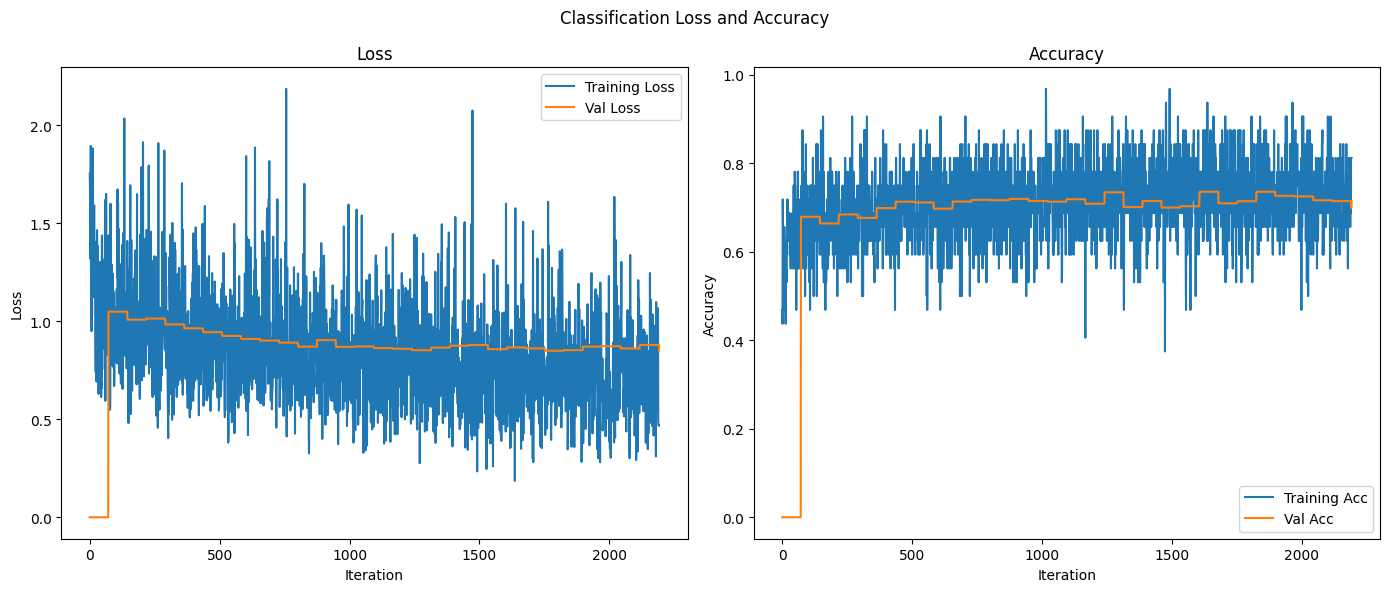

In [50]:
plot_graph_plt_nn(res_var, f"Classification Loss and Accuracy")